In [1]:
# packages
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from supportfunctions import PDESolver_2d, finiteDiff
from solver_2d import false_transient_one_iteration_python
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
from derivative import derivatives_2d, derivative_1d
import SolveLinSys
import time
from solver_ode import solve_ode, solve_ode_one
from solver_jump import approach_one, solve_smooth
from solver import pde_solve
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
from multiprocessing import Pool
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams["figure.edgecolor"] = "w"
mpl.rcParams['figure.facecolor'] = "w"
mpl.rcParams["savefig.dpi"] = 300


# Adding robustness and ambiguity:

Process:

$$
dY_t^1  = Y_t^2 dt
$$

$$
dY_t^2 =   - \lambda Y_t^2 dt + \lambda \theta \mathcal{E} dt
$$


HJB:

$$
\begin{aligned}
0 = \max_{\mathcal{E}} \min_{\omega_\ell } & - \delta \phi(y_1, y_2) + \eta log(\mathcal{E}) \\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 + \sum_{\ell}^L 
\omega_\ell  \theta_\ell \mathcal{E}) \\ 
& + \frac{(\eta - 1)}{\delta} \left(\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\} \right) y_2 \\
& + \xi_a \sum_{\ell}^L \omega_\ell (\log \omega_\ell - \log \pi^a_i)
\end{aligned}
$$

$$
    \hat \pi^{a,*}_i \propto \pi_i^a \exp\left( -\frac{1}{\xi_a} \frac{\partial \phi}{\partial y_2}\lambda \theta_i \mathcal{E} \right)
$$

and
$$
\mathcal{E}^* = - \frac{\eta}{\frac{\partial \phi }{\partial y_2} \lambda \sum_i \hat\pi^a_i\theta_i}
$$
Plug back in:

$$
\begin{aligned}
0 = \max_{\mathcal{E}}  & - \delta \phi(y) +  \eta log(\mathcal{E}) \\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2) \\ 
& + \frac{(\eta - 1)}{\delta} (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2 \\
& - \xi_a  \log \left(\sum_i\hat \pi^a_i \exp( -\frac{1}{\xi_a} \frac{\partial \phi}{\partial y_2}\lambda \theta_i \mathcal{E}) \right)
\end{aligned}
$$

$$
\phi(\bar y_1, y_2) \approx  - \xi_p \log \left (\sum_m \pi_m^p \exp\left[-\frac{1}{\xi_p }\phi_m(\bar y_1, y_2) \right] \right) 
$$

In [2]:
# parameters
δ = 0.01
η = 0.032
ξa = 0.01
θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
θ = np.mean(θ_list)
σy = 1.2*θ
# damage function
ȳ = 2
γ1 = 0.00017675
γ2 = 2*0.0022
γ3_list = np.linspace(0., 1./3, 20)
# y grid
# λ = np.log(2)/6
λ = 1

In [3]:
y1_step = .04
y1_grid = np.arange(0., 4., y1_step)

y2_step = .001
y2_grid = np.arange(0., .05, y2_step)

(y1_mat, y2_mat) = np.meshgrid(y1_grid, y2_grid, indexing = 'ij')
stateSpace = np.hstack([y1_mat.reshape(-1,1, order='F'), y2_mat.reshape(-1,1,order='F')])
hy1 = y1_grid[1] - y1_grid[0]
hy2 = y2_grid[1] - y2_grid[0]
n_y1 = len(y1_grid)
n_y2 = len(y2_grid)

In [4]:
tol = 1e-7
ϵ = .1
πa_o = np.ones((len(θ_list), n_y1, n_y2))/len(θ_list)
θ_mat = np.zeros((len(θ_list), n_y1, n_y2))
for i in range(len(θ_list)):
    θ_mat[i] = θ_list[i]
πa = πa_o


def solve_prep(y1_mat, y2_mat, γ3, tol=1e-7, ϵ=1, max_iter=2000, fraction=0.05):
    πa_o = np.ones((len(θ_list), n_y1, n_y2))/len(θ_list)
    θ_mat = np.zeros((len(θ_list), n_y1, n_y2))
    for i in range(len(θ_list)):
        θ_mat[i] = θ_list[i]
    πa = πa_o
    dΛ1 = γ1 + γ2*y1_mat + γ3*(y1_mat - ȳ)*(y1_mat >ȳ)
    ems_new = η*np.ones(y1_mat.shape)
    ems_old = ems_new
    episode = 0
    lhs_error = 0.5
    while lhs_error > tol and episode  < max_iter:
        if episode ==0:
            v0 =  - η*((y1_mat+y2_mat) + (y1_mat+y2_mat)**2)
        else:
            vold = v0.copy()
        v0_dy1 = derivatives_2d(v0,0,1,hy1)
        v0_dy2 = derivatives_2d(v0,1,1,hy2)
        # updating controls
        ems_new =  - η/(v0_dy2*λ*np.sum(θ_mat*πa, axis=0))
        ems_new[ems_new <= 1e-15] = 1e-15
        ems = ems_new*fraction + ems_old*(1 - fraction)
        
        weight = np.array([-1/ξa*v0_dy2*λ*ems*θ for θ in θ_list])
        weight = weight - np.max(weight, axis=0)
        πa = πa_o*np.exp(weight)
#         πa[πa<1e-15] = 1e-15
        πa = πa/np.sum(πa, axis=0)
        
#         print(np.min(ems))
        # HJB coefficient
        A =  -δ*np.ones(y1_mat.shape)
        B_y1 =  y2_mat
        B_y2 = λ*( - y2_mat + ems*np.sum(θ_mat*πa, axis=0))
        C_yy1 = np.zeros(y1_mat.shape)
        C_yy2 = np.zeros(y1_mat.shape)
        D = η*np.log(ems) +  (η-1)/δ*dΛ1*y2_mat + ξa*np.sum(πa*(np.log(πa) - np.log(πa_o)), axis=0) 
        # PDE solver
        solve_start = time.time()
        out = PDESolver_2d(stateSpace, A, B_y1, B_y2, C_yy1, C_yy2, D, v0, ϵ, solverType = 'False Transient')
        out_comp = out[2].reshape(v0.shape,order = "F")
        rhs = A*v0 + B_y1*v0_dy1 + B_y2*v0_dy2  + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((out_comp - v0)/ϵ))
        #     if episode % 1 == 0:
#         print("Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
        episode += 1
        v0 = out_comp
        ems_old = ems
#         print("End of PDE solver, takes time: {}".format(time.time() - solve_start))
    
    print("Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
    result = dict(v0=v0, ems=ems, πa=πa)
    return result

In [5]:
def ode_y_parallel(args_list):
    with Pool() as p:
        res_list = p.starmap(solve_prep, args_list)
    return res_list        

def postjump_list(args_list):
    res_list = ode_y_parallel(args_list)
    ϕ_list = np.zeros((len(γ3_list), len(y1_grid), len(y2_grid)))
    ems_list = np.zeros((len(γ3_list), len(y1_grid), len(y2_grid)))
    for j in range(len(γ3_list)):
        ϕ_list[j] = res_list[j]['v0']
        ems_list[j] = res_list[j]['ems']
        
    return ϕ_list, ems_list

args_list_test  = []
for γ3_i in γ3_list:
    args_iter = (y1_mat, y2_mat, γ3_i, 1e-6, 1., 1000, 0.05)
    args_list_test.append(args_iter)
ϕ_list, ems_list = postjump_list(args_list_test)

Episode 1000: PDE Error: 0.000289411670; False Transient Error: 0.000001161700; Iterations: 584; CG Error: 0.000000000098
Episode 957: PDE Error: 0.002042111889; False Transient Error: 0.000000995661; Iterations: 697; CG Error: 0.000000000098
Episode 1000: PDE Error: 0.016472298678; False Transient Error: 0.000002347391; Iterations: 778; CG Error: 0.000000000099
Episode 1000: PDE Error: 0.006265141508; False Transient Error: 0.000001631688; Iterations: 781; CG Error: 0.000000000099
Episode 1000: PDE Error: 0.032310887478; False Transient Error: 0.000002476669; Iterations: 758; CG Error: 0.000000000096
Episode 1000: PDE Error: 0.038141265845; False Transient Error: 0.000002397040; Iterations: 747; CG Error: 0.000000000096
Episode 1000: PDE Error: 0.028391879423; False Transient Error: 0.000002499763; Iterations: 775; CG Error: 0.000000000098
Episode 1000: PDE Error: 0.024443394645; False Transient Error: 0.000002491579; Iterations: 783; CG Error: 0.000000000099
Episode 1000: PDE Error: 

In [5]:
ϕ_list = np.load("v_list_1.npy")
ems_list = np.load("e_list_1.npy")

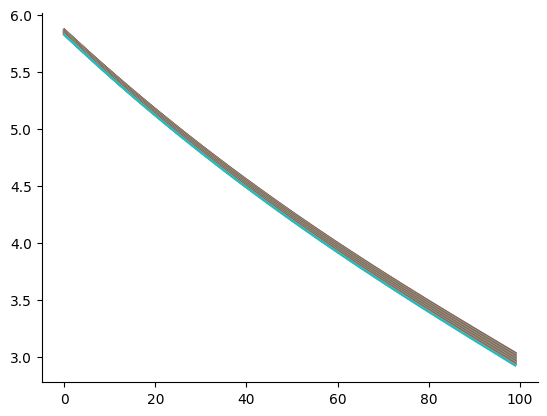

In [6]:
loc_start = np.abs(y2_grid - np.mean(θ_list)).argmin()
loc_twi = np.abs(y2_grid - 2 * np.mean(θ_list)).argmin()
loc_tri = np.abs(y2_grid - 3 * np.mean(θ_list)).argmin()
plt.plot(ϕ_list[0])
plt.show()

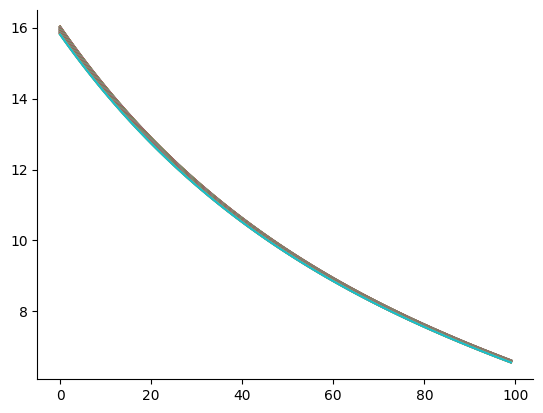

In [16]:
plt.plot(ems_list[0])
# plt.ylim(-6,6)
plt.show()

In [8]:
y1_grid_cap = np.arange(0., 2.1 + y1_step, y1_step)
loc_2 = np.abs(y1_grid - 2.).argmin()
ξp = 1
ϵ = 0.1
max_iter = 20_000
dmg_weight = np.ones(len(γ3_list)) / len(γ3_list)
ϕ_weight = np.average(np.exp(-1 / ξp * ϕ_list), axis=0, weights=dmg_weight)

ϕ_equiv = -ξp * np.log(ϕ_weight)

(y1_mat_cap, y2_mat_cap) = np.meshgrid(y1_grid_cap, y2_grid, indexing='ij')
dy1 = y1_grid_cap[1] - y1_grid[0]
dy2 = y2_grid[1] - y2_grid[0]
num_y1 = len(y1_grid_cap)
num_y2 = len(y2_grid)
πd_o = np.ones((len(γ3_list), num_y1, num_y2)) / len(γ3_list)
πa_o = np.ones((len(θ_list), num_y1, num_y2)) / len(θ_list)
θ_mat = np.zeros((len(θ_list), num_y1, num_y2))
for i in range(len(θ_list)):
    θ_mat[i] = θ_list[i]
dΛ1 = γ1 + γ2 * y1_mat_cap

r1 = 1.5
r2 = 2.5
y_lower = 1.5
Intensity = r1 * (np.exp(r2 / 2 * (y1_mat_cap - y_lower)**2) -
                  1) * (y1_mat_cap >= y_lower)

# initiate v and control
tol = 1e-6
ems = η
ems_old = ems
lhs_error = 1
episode = 0
v0 = ϕ_equiv[:num_y1]
v_m = np.zeros(πd_o.shape)
for i in range(len(γ3_list)):
    v_m[i] = ϕ_list[i][loc_2]

while lhs_error > tol and episode < max_iter:
    v0_old = v0.copy()
    v0_dy1 = derivatives_2d(v0, 0, 1, hy1)
    v0_dy2 = derivatives_2d(v0, 1, 1, hy2)
    # updating controls
    weight = np.array([-1 / ξa * v0_dy2 * λ * ems_old * θ for θ in θ_list])
    weight = weight - np.max(weight, axis=0)
    πa = πa_o * np.exp(weight)
    πa[πa < 1e-15] = 1e-15
    πa = πa / np.sum(πa, axis=0)
    ems_new = -η / (v0_dy2 * λ * np.sum(θ_mat * πa, axis=0))
    ems_new[ems_new <= 1e-15] = 1e-15
    ems = ems_new * 0.05 + ems_old * 0.95
    #     print(np.min(ems))
    g_m = np.exp(1 / ξp * (v0 - v_m))
    # HJB coefficient
    A = -δ * np.ones(y1_mat_cap.shape) - Intensity * np.sum(πd_o * g_m, axis=0)
    B_y1 = y2_mat_cap
    B_y2 = λ * (-y2_mat_cap + ems * np.sum(θ_mat * πa, axis=0))
    C_yy1 = np.zeros(y1_mat_cap.shape)
    C_yy2 = np.zeros(y1_mat_cap.shape)
    D = η * np.log(ems) + (η - 1) / δ * dΛ1 * y2_mat_cap + ξa * np.sum(
        πa * (np.log(πa) - np.log(πa_o)), axis=0) + Intensity * np.sum(
            πd_o * g_m * v_m, axis=0) + ξp * Intensity * np.sum(
                πd_o * (1 - g_m + g_m * np.log(g_m)), axis=0)
    phi_mat = false_transient_one_iteration_python(
        A,
        B_y1,
        B_y2,
        C_yy1,
        C_yy2,
        D,
        v0,
        ϵ,
        hy1,
        hy2,
        bc=(np.zeros(num_y2), ϕ_equiv[num_y1 - 1], np.zeros(num_y1),
            np.zeros(num_y1)),
        impose_bc=(False, False, False, False))

    rhs = A * phi_mat + B_y1 * v0_dy1 + B_y2 * v0_dy2 + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((phi_mat - v0_old) / ϵ))
    v0 = phi_mat
    ems_old = ems
    episode += 1
    print('Episode: {:d}\t lhs error: {:.12f}\t rhs error: {:.12f}'.format(episode, lhs_error, rhs_error))

Exception ignored on calling ctypes callback function: <function ExecutionEngine._raw_object_cache_notify at 0x144b3dc10>
Traceback (most recent call last):
  File "/Users/surich/.pyenv/versions/3.8.11/envs/macro-ann/lib/python3.8/site-packages/llvmlite/binding/executionengine.py", line 171, in _raw_object_cache_notify
    def _raw_object_cache_notify(self, data):
KeyboardInterrupt: 


Episode: 1	 lhs error: 0.589236468914	 rhs error: 0.582902771052
Episode: 2	 lhs error: 0.584449391191	 rhs error: 0.580135693883
Episode: 3	 lhs error: 0.574148546155	 rhs error: 0.568710978361
Episode: 4	 lhs error: 0.556253299935	 rhs error: 0.552436667622
Episode: 5	 lhs error: 0.537166893639	 rhs error: 0.533074109868
Episode: 6	 lhs error: 0.515211254369	 rhs error: 0.511574586371
Episode: 7	 lhs error: 0.491248636672	 rhs error: 0.488713746014
Episode: 8	 lhs error: 0.467113226865	 rhs error: 0.464999086776
Episode: 9	 lhs error: 0.443325845402	 rhs error: 0.440774396638
Episode: 10	 lhs error: 0.418110401871	 rhs error: 0.416452469923
Episode: 11	 lhs error: 0.394250645497	 rhs error: 0.392216429638
Episode: 12	 lhs error: 0.369805705320	 rhs error: 0.368378134007
Episode: 13	 lhs error: 0.346684835266	 rhs error: 0.344984610327
Episode: 14	 lhs error: 0.323792277460	 rhs error: 0.322316408195
Episode: 15	 lhs error: 0.301775009972	 rhs error: 0.300444353974
Episode: 16	 lhs er

Episode: 125	 lhs error: 0.042560714992	 rhs error: 0.121949215312
Episode: 126	 lhs error: 0.042108003248	 rhs error: 0.121906563181
Episode: 127	 lhs error: 0.042146829015	 rhs error: 0.121848431287
Episode: 128	 lhs error: 0.041711623881	 rhs error: 0.121799200417
Episode: 129	 lhs error: 0.041793928386	 rhs error: 0.121730219166
Episode: 130	 lhs error: 0.041725691694	 rhs error: 0.121671025555
Episode: 131	 lhs error: 0.041412801038	 rhs error: 0.121623193935
Episode: 132	 lhs error: 0.041249230313	 rhs error: 0.121546211559
Episode: 133	 lhs error: 0.041171511805	 rhs error: 0.121464313238
Episode: 134	 lhs error: 0.040810282433	 rhs error: 0.121384543480
Episode: 135	 lhs error: 0.040856694651	 rhs error: 0.121295346668
Episode: 136	 lhs error: 0.040727338140	 rhs error: 0.121203130456
Episode: 137	 lhs error: 0.040677177944	 rhs error: 0.121105205749
Episode: 138	 lhs error: 0.040630768435	 rhs error: 0.121009458688
Episode: 139	 lhs error: 0.040581507874	 rhs error: 0.12092499

Episode: 248	 lhs error: 0.029126449446	 rhs error: 0.120915864736
Episode: 249	 lhs error: 0.029151109007	 rhs error: 0.120644788927
Episode: 250	 lhs error: 0.029101967658	 rhs error: 0.120376784911
Episode: 251	 lhs error: 0.028886311909	 rhs error: 0.120104140127
Episode: 252	 lhs error: 0.029073416390	 rhs error: 0.119819289773
Episode: 253	 lhs error: 0.028824196765	 rhs error: 0.119548599271
Episode: 254	 lhs error: 0.028689456412	 rhs error: 0.119259553836
Episode: 255	 lhs error: 0.028592224287	 rhs error: 0.118963875870
Episode: 256	 lhs error: 0.028476216231	 rhs error: 0.118663802434
Episode: 257	 lhs error: 0.028402258575	 rhs error: 0.118355118935
Episode: 258	 lhs error: 0.028469988622	 rhs error: 0.118043866639
Episode: 259	 lhs error: 0.028239774817	 rhs error: 0.117738112738
Episode: 260	 lhs error: 0.028311343535	 rhs error: 0.117417354809
Episode: 261	 lhs error: 0.028059224342	 rhs error: 0.117103762967
Episode: 262	 lhs error: 0.027974491177	 rhs error: 0.11677415

Episode: 371	 lhs error: 0.022203457657	 rhs error: 0.079412413782
Episode: 372	 lhs error: 0.022182821027	 rhs error: 0.079135031276
Episode: 373	 lhs error: 0.022170706482	 rhs error: 0.078855743087
Episode: 374	 lhs error: 0.022108960812	 rhs error: 0.078575117507
Episode: 375	 lhs error: 0.022088479167	 rhs error: 0.078289130569
Episode: 376	 lhs error: 0.021962995885	 rhs error: 0.078003220144
Episode: 377	 lhs error: 0.022048008107	 rhs error: 0.077708864350
Episode: 378	 lhs error: 0.021922698037	 rhs error: 0.077419056118
Episode: 379	 lhs error: 0.022067797490	 rhs error: 0.077122193715
Episode: 380	 lhs error: 0.021895065968	 rhs error: 0.076834014323
Episode: 381	 lhs error: 0.021879272502	 rhs error: 0.076536026949
Episode: 382	 lhs error: 0.021809654638	 rhs error: 0.076236622766
Episode: 383	 lhs error: 0.021824578703	 rhs error: 0.075933676435
Episode: 384	 lhs error: 0.021809317200	 rhs error: 0.075629602019
Episode: 385	 lhs error: 0.021872154426	 rhs error: 0.07533030

Episode: 494	 lhs error: 0.017696912157	 rhs error: 0.043092017070
Episode: 495	 lhs error: 0.017654120662	 rhs error: 0.042870993128
Episode: 496	 lhs error: 0.017621524530	 rhs error: 0.042649179955
Episode: 497	 lhs error: 0.017603359158	 rhs error: 0.042426607560
Episode: 498	 lhs error: 0.017584955257	 rhs error: 0.042203309534
Episode: 499	 lhs error: 0.017566296751	 rhs error: 0.041979323316
Episode: 500	 lhs error: 0.017547280157	 rhs error: 0.041754672463
Episode: 501	 lhs error: 0.017527983575	 rhs error: 0.041529389157
Episode: 502	 lhs error: 0.017508442037	 rhs error: 0.041303505068
Episode: 503	 lhs error: 0.017488533968	 rhs error: 0.041077054578
Episode: 504	 lhs error: 0.017468384827	 rhs error: 0.040850064204
Episode: 505	 lhs error: 0.017447897048	 rhs error: 0.040622566867
Episode: 506	 lhs error: 0.017427221023	 rhs error: 0.040394593307
Episode: 507	 lhs error: 0.017406162836	 rhs error: 0.040166181189
Episode: 508	 lhs error: 0.017384828987	 rhs error: 0.03993735

Episode: 617	 lhs error: 0.014581832946	 rhs error: 0.029325864417
Episode: 618	 lhs error: 0.014565671849	 rhs error: 0.029304034967
Episode: 619	 lhs error: 0.014549307841	 rhs error: 0.029282533513
Episode: 620	 lhs error: 0.014532755481	 rhs error: 0.029261356325
Episode: 621	 lhs error: 0.014515948266	 rhs error: 0.029240501614
Episode: 622	 lhs error: 0.014498941370	 rhs error: 0.029219961579
Episode: 623	 lhs error: 0.014481736339	 rhs error: 0.029199733162
Episode: 624	 lhs error: 0.014464328386	 rhs error: 0.029179813375
Episode: 625	 lhs error: 0.014446702679	 rhs error: 0.029160199090
Episode: 626	 lhs error: 0.014428809738	 rhs error: 0.029140885848
Episode: 627	 lhs error: 0.014410736600	 rhs error: 0.029121864486
Episode: 628	 lhs error: 0.014392435840	 rhs error: 0.029103134823
Episode: 629	 lhs error: 0.014373953192	 rhs error: 0.029084690943
Episode: 630	 lhs error: 0.014355224092	 rhs error: 0.029066532105
Episode: 631	 lhs error: 0.014336281391	 rhs error: 0.02904865

Episode: 740	 lhs error: 0.012241207182	 rhs error: 0.028169801969
Episode: 741	 lhs error: 0.012224721726	 rhs error: 0.028167446172
Episode: 742	 lhs error: 0.012208061357	 rhs error: 0.028165138040
Episode: 743	 lhs error: 0.012191223395	 rhs error: 0.028162876387
Episode: 744	 lhs error: 0.012174214100	 rhs error: 0.028160659687
Episode: 745	 lhs error: 0.012157028343	 rhs error: 0.028158487330
Episode: 746	 lhs error: 0.012139658419	 rhs error: 0.028156358168
Episode: 747	 lhs error: 0.012122122181	 rhs error: 0.028154270025
Episode: 748	 lhs error: 0.012104406294	 rhs error: 0.028152223120
Episode: 749	 lhs error: 0.012086513861	 rhs error: 0.028150215759
Episode: 750	 lhs error: 0.012068446454	 rhs error: 0.028148246900
Episode: 751	 lhs error: 0.012050209249	 rhs error: 0.028146315602
Episode: 752	 lhs error: 0.012031795636	 rhs error: 0.028144421685
Episode: 753	 lhs error: 0.012013195039	 rhs error: 0.028142564033
Episode: 754	 lhs error: 0.011994431312	 rhs error: 0.02814074

Episode: 863	 lhs error: 0.010314505418	 rhs error: 0.028032746534
Episode: 864	 lhs error: 0.010303337761	 rhs error: 0.028032233084
Episode: 865	 lhs error: 0.010292047120	 rhs error: 0.028031728926
Episode: 866	 lhs error: 0.010280629591	 rhs error: 0.028031234449
Episode: 867	 lhs error: 0.010269083046	 rhs error: 0.028030749360
Episode: 868	 lhs error: 0.010257413131	 rhs error: 0.028030273060
Episode: 869	 lhs error: 0.010245618181	 rhs error: 0.028029806109
Episode: 870	 lhs error: 0.010233695953	 rhs error: 0.028029348579
Episode: 871	 lhs error: 0.010221648659	 rhs error: 0.028028900291
Episode: 872	 lhs error: 0.010209476215	 rhs error: 0.028028461385
Episode: 873	 lhs error: 0.010197175279	 rhs error: 0.028028032092
Episode: 874	 lhs error: 0.010184750554	 rhs error: 0.028027612021
Episode: 875	 lhs error: 0.010172197293	 rhs error: 0.028027201658
Episode: 876	 lhs error: 0.010159515611	 rhs error: 0.028026800628
Episode: 877	 lhs error: 0.010146708039	 rhs error: 0.02802640

Episode: 986	 lhs error: 0.008794338799	 rhs error: 0.028020430156
Episode: 987	 lhs error: 0.008785002695	 rhs error: 0.028020480302
Episode: 988	 lhs error: 0.008775566917	 rhs error: 0.028020529020
Episode: 989	 lhs error: 0.008766030379	 rhs error: 0.028020576228
Episode: 990	 lhs error: 0.008756393649	 rhs error: 0.028020621741
Episode: 991	 lhs error: 0.008746656449	 rhs error: 0.028020665547
Episode: 992	 lhs error: 0.008736818652	 rhs error: 0.028020707603
Episode: 993	 lhs error: 0.008726880430	 rhs error: 0.028020747801
Episode: 994	 lhs error: 0.008716842633	 rhs error: 0.028020786145
Episode: 995	 lhs error: 0.008706704782	 rhs error: 0.028020822875
Episode: 996	 lhs error: 0.008696465147	 rhs error: 0.028020858085
Episode: 997	 lhs error: 0.008686125225	 rhs error: 0.028020891503
Episode: 998	 lhs error: 0.008675684343	 rhs error: 0.028020923297
Episode: 999	 lhs error: 0.008665142618	 rhs error: 0.028020953520
Episode: 1000	 lhs error: 0.008654499159	 rhs error: 0.0280209

Episode: 1109	 lhs error: 0.007554436416	 rhs error: 0.028017129378
Episode: 1110	 lhs error: 0.007545382378	 rhs error: 0.028017009269
Episode: 1111	 lhs error: 0.007536244792	 rhs error: 0.028016886016
Episode: 1112	 lhs error: 0.007527024438	 rhs error: 0.028016759405
Episode: 1113	 lhs error: 0.007517720864	 rhs error: 0.028016629597
Episode: 1114	 lhs error: 0.007508334032	 rhs error: 0.028016496541
Episode: 1115	 lhs error: 0.007498863977	 rhs error: 0.028016360279
Episode: 1116	 lhs error: 0.007489309865	 rhs error: 0.028016220806
Episode: 1117	 lhs error: 0.007479672078	 rhs error: 0.028016077854
Episode: 1118	 lhs error: 0.007469951007	 rhs error: 0.028015931330
Episode: 1119	 lhs error: 0.007460146512	 rhs error: 0.028015781349
Episode: 1120	 lhs error: 0.007450258166	 rhs error: 0.028015628058
Episode: 1121	 lhs error: 0.007440285615	 rhs error: 0.028015471286
Episode: 1122	 lhs error: 0.007430229464	 rhs error: 0.028015310868
Episode: 1123	 lhs error: 0.007420089149	 rhs er

Episode: 1230	 lhs error: 0.006519069711	 rhs error: 0.027995642856
Episode: 1231	 lhs error: 0.006512213969	 rhs error: 0.027995645440
Episode: 1232	 lhs error: 0.006505292773	 rhs error: 0.027995652264
Episode: 1233	 lhs error: 0.006498306082	 rhs error: 0.027995663255
Episode: 1234	 lhs error: 0.006491253861	 rhs error: 0.027995678242
Episode: 1235	 lhs error: 0.006484135960	 rhs error: 0.027995697036
Episode: 1236	 lhs error: 0.006476952317	 rhs error: 0.027995719662
Episode: 1237	 lhs error: 0.006469702912	 rhs error: 0.027995746161
Episode: 1238	 lhs error: 0.006462387678	 rhs error: 0.027995776141
Episode: 1239	 lhs error: 0.006455006490	 rhs error: 0.027995809472
Episode: 1240	 lhs error: 0.006447559340	 rhs error: 0.027995846050
Episode: 1241	 lhs error: 0.006440046119	 rhs error: 0.027995885805
Episode: 1242	 lhs error: 0.006432466797	 rhs error: 0.027995928530
Episode: 1243	 lhs error: 0.006424821226	 rhs error: 0.027995974146
Episode: 1244	 lhs error: 0.006417109435	 rhs er

Episode: 1353	 lhs error: 0.005643759702	 rhs error: 0.027985622545
Episode: 1354	 lhs error: 0.005637594141	 rhs error: 0.027985369423
Episode: 1355	 lhs error: 0.005631373093	 rhs error: 0.027985119561
Episode: 1356	 lhs error: 0.005625096550	 rhs error: 0.027984872969
Episode: 1357	 lhs error: 0.005618763747	 rhs error: 0.027984629688
Episode: 1358	 lhs error: 0.005612375087	 rhs error: 0.027984390196
Episode: 1359	 lhs error: 0.005605930877	 rhs error: 0.027984154549
Episode: 1360	 lhs error: 0.005599430803	 rhs error: 0.027983922749
Episode: 1361	 lhs error: 0.005592874895	 rhs error: 0.027983694996
Episode: 1362	 lhs error: 0.005586262779	 rhs error: 0.027983471265
Episode: 1363	 lhs error: 0.005579594589	 rhs error: 0.027983251823
Episode: 1364	 lhs error: 0.005572869955	 rhs error: 0.027983036693
Episode: 1365	 lhs error: 0.005566089319	 rhs error: 0.027982826221
Episode: 1366	 lhs error: 0.005559252683	 rhs error: 0.027982620367
Episode: 1367	 lhs error: 0.005552359645	 rhs er

Episode: 1476	 lhs error: 0.004892316504	 rhs error: 0.027987437342
Episode: 1477	 lhs error: 0.004886123805	 rhs error: 0.027987525018
Episode: 1478	 lhs error: 0.004880003453	 rhs error: 0.027987607022
Episode: 1479	 lhs error: 0.004875040611	 rhs error: 0.027987683042
Episode: 1480	 lhs error: 0.004870034881	 rhs error: 0.027987752887
Episode: 1481	 lhs error: 0.004864987312	 rhs error: 0.027987816496
Episode: 1482	 lhs error: 0.004859897507	 rhs error: 0.027987873542
Episode: 1483	 lhs error: 0.004854764794	 rhs error: 0.027987923935
Episode: 1484	 lhs error: 0.004849589523	 rhs error: 0.027987967538
Episode: 1485	 lhs error: 0.004844372509	 rhs error: 0.027988004195
Episode: 1486	 lhs error: 0.004839111257	 rhs error: 0.027988033597
Episode: 1487	 lhs error: 0.004833807773	 rhs error: 0.027988056028
Episode: 1488	 lhs error: 0.004828461887	 rhs error: 0.027988071192
Episode: 1489	 lhs error: 0.004823073329	 rhs error: 0.027988078885
Episode: 1490	 lhs error: 0.004817641046	 rhs er

Episode: 1599	 lhs error: 0.004257998075	 rhs error: 0.027969779293
Episode: 1600	 lhs error: 0.004253452882	 rhs error: 0.027969771481
Episode: 1601	 lhs error: 0.004248869171	 rhs error: 0.027969769650
Episode: 1602	 lhs error: 0.004244246201	 rhs error: 0.027969773684
Episode: 1603	 lhs error: 0.004239583876	 rhs error: 0.027969783599
Episode: 1604	 lhs error: 0.004234883638	 rhs error: 0.027969799459
Episode: 1605	 lhs error: 0.004230143991	 rhs error: 0.027969821030
Episode: 1606	 lhs error: 0.004225365709	 rhs error: 0.027969848403
Episode: 1607	 lhs error: 0.004220548099	 rhs error: 0.027969881431
Episode: 1608	 lhs error: 0.004215692063	 rhs error: 0.027969920137
Episode: 1609	 lhs error: 0.004210797268	 rhs error: 0.027969964482
Episode: 1610	 lhs error: 0.004205863818	 rhs error: 0.027970014404
Episode: 1611	 lhs error: 0.004200891176	 rhs error: 0.027970069693
Episode: 1612	 lhs error: 0.004195879918	 rhs error: 0.027970130377
Episode: 1613	 lhs error: 0.004190829753	 rhs er

Episode: 1722	 lhs error: 0.003646769885	 rhs error: 0.027989255831
Episode: 1723	 lhs error: 0.003640436029	 rhs error: 0.027989417445
Episode: 1724	 lhs error: 0.003634067194	 rhs error: 0.027989578714
Episode: 1725	 lhs error: 0.003627662131	 rhs error: 0.027989739405
Episode: 1726	 lhs error: 0.003621221184	 rhs error: 0.027989899625
Episode: 1727	 lhs error: 0.003614743794	 rhs error: 0.027990059416
Episode: 1728	 lhs error: 0.003608232201	 rhs error: 0.027990218846
Episode: 1729	 lhs error: 0.003601682820	 rhs error: 0.027990377704
Episode: 1730	 lhs error: 0.003595098918	 rhs error: 0.027990536395
Episode: 1731	 lhs error: 0.003588479198	 rhs error: 0.027990694628
Episode: 1732	 lhs error: 0.003581823103	 rhs error: 0.027990852557
Episode: 1733	 lhs error: 0.003575131645	 rhs error: 0.027991010241
Episode: 1734	 lhs error: 0.003568405525	 rhs error: 0.027991167693
Episode: 1735	 lhs error: 0.003561643474	 rhs error: 0.027991324817
Episode: 1736	 lhs error: 0.003554845950	 rhs er

Episode: 1845	 lhs error: 0.002649827738	 rhs error: 0.027983059596
Episode: 1846	 lhs error: 0.002640732075	 rhs error: 0.027982135999
Episode: 1847	 lhs error: 0.002631632701	 rhs error: 0.027981183331
Episode: 1848	 lhs error: 0.002622529639	 rhs error: 0.027980201608
Episode: 1849	 lhs error: 0.002613423342	 rhs error: 0.027979190927
Episode: 1850	 lhs error: 0.002604312683	 rhs error: 0.027978151405
Episode: 1851	 lhs error: 0.002595197704	 rhs error: 0.027977083283
Episode: 1852	 lhs error: 0.002586079163	 rhs error: 0.027975986745
Episode: 1853	 lhs error: 0.002576956585	 rhs error: 0.027974862015
Episode: 1854	 lhs error: 0.002567829449	 rhs error: 0.027973709390
Episode: 1855	 lhs error: 0.002558697444	 rhs error: 0.027972529168
Episode: 1856	 lhs error: 0.002549560394	 rhs error: 0.027971321812
Episode: 1857	 lhs error: 0.002540418588	 rhs error: 0.027970087759
Episode: 1858	 lhs error: 0.002531272468	 rhs error: 0.027968827404
Episode: 1859	 lhs error: 0.002522121323	 rhs er

Episode: 1968	 lhs error: 0.001524071702	 rhs error: 0.027818902066
Episode: 1969	 lhs error: 0.001515444861	 rhs error: 0.027818507711
Episode: 1970	 lhs error: 0.001506838092	 rhs error: 0.027818141143
Episode: 1971	 lhs error: 0.001498250784	 rhs error: 0.027817802343
Episode: 1972	 lhs error: 0.001489683704	 rhs error: 0.027817491376
Episode: 1973	 lhs error: 0.001481136529	 rhs error: 0.027817208201
Episode: 1974	 lhs error: 0.001472610524	 rhs error: 0.027816952865
Episode: 1975	 lhs error: 0.001464105041	 rhs error: 0.027816725257
Episode: 1976	 lhs error: 0.001455620621	 rhs error: 0.027816525444
Episode: 1977	 lhs error: 0.001447156595	 rhs error: 0.027816353349
Episode: 1978	 lhs error: 0.001438714173	 rhs error: 0.027816209048
Episode: 1979	 lhs error: 0.001430293467	 rhs error: 0.027816092444
Episode: 1980	 lhs error: 0.001421894237	 rhs error: 0.027816003454
Episode: 1981	 lhs error: 0.001413516985	 rhs error: 0.027815942090
Episode: 1982	 lhs error: 0.001405162135	 rhs er

Episode: 2091	 lhs error: 0.000658737176	 rhs error: 0.027949305774
Episode: 2092	 lhs error: 0.000653539382	 rhs error: 0.027950257754
Episode: 2093	 lhs error: 0.000648371421	 rhs error: 0.027951198383
Episode: 2094	 lhs error: 0.000643232973	 rhs error: 0.027952127623
Episode: 2095	 lhs error: 0.000638124452	 rhs error: 0.027953045467
Episode: 2096	 lhs error: 0.000633045888	 rhs error: 0.027953951828
Episode: 2097	 lhs error: 0.000627997093	 rhs error: 0.027954846623
Episode: 2098	 lhs error: 0.000622977465	 rhs error: 0.027955729791
Episode: 2099	 lhs error: 0.000617987203	 rhs error: 0.027956601355
Episode: 2100	 lhs error: 0.000613025999	 rhs error: 0.027957461291
Episode: 2101	 lhs error: 0.000608094675	 rhs error: 0.027958309620
Episode: 2102	 lhs error: 0.000603192597	 rhs error: 0.027959146208
Episode: 2103	 lhs error: 0.000598319359	 rhs error: 0.027959971047
Episode: 2104	 lhs error: 0.000593475518	 rhs error: 0.027960784161
Episode: 2105	 lhs error: 0.000588660774	 rhs er

Episode: 2213	 lhs error: 0.000222268315	 rhs error: 0.028055843142
Episode: 2214	 lhs error: 0.000220302728	 rhs error: 0.028055962420
Episode: 2215	 lhs error: 0.000218370638	 rhs error: 0.028056049517
Episode: 2216	 lhs error: 0.000216471938	 rhs error: 0.028056103367
Episode: 2217	 lhs error: 0.000214606320	 rhs error: 0.028056123023
Episode: 2218	 lhs error: 0.000212774294	 rhs error: 0.028056107578
Episode: 2219	 lhs error: 0.000210976770	 rhs error: 0.028056056112
Episode: 2220	 lhs error: 0.000209213367	 rhs error: 0.028055967555
Episode: 2221	 lhs error: 0.000207484145	 rhs error: 0.028055840969
Episode: 2222	 lhs error: 0.000205789646	 rhs error: 0.028055675464
Episode: 2223	 lhs error: 0.000204129984	 rhs error: 0.028055470078
Episode: 2224	 lhs error: 0.000202505641	 rhs error: 0.028055223852
Episode: 2225	 lhs error: 0.000200916123	 rhs error: 0.028054935810
Episode: 2226	 lhs error: 0.000199361350	 rhs error: 0.028054605126
Episode: 2227	 lhs error: 0.000197841654	 rhs er

Episode: 2336	 lhs error: 0.000112024566	 rhs error: 0.027887588767
Episode: 2337	 lhs error: 0.000111314115	 rhs error: 0.027886929060
Episode: 2338	 lhs error: 0.000110602998	 rhs error: 0.027886307135
Episode: 2339	 lhs error: 0.000109891537	 rhs error: 0.027885723102
Episode: 2340	 lhs error: 0.000109180015	 rhs error: 0.027885177040
Episode: 2341	 lhs error: 0.000108467792	 rhs error: 0.027884668944
Episode: 2342	 lhs error: 0.000107755276	 rhs error: 0.027884198894
Episode: 2343	 lhs error: 0.000107041995	 rhs error: 0.027883766897
Episode: 2344	 lhs error: 0.000106328760	 rhs error: 0.027883373028
Episode: 2345	 lhs error: 0.000105615316	 rhs error: 0.027883017235
Episode: 2346	 lhs error: 0.000104901686	 rhs error: 0.027882699462
Episode: 2347	 lhs error: 0.000104188219	 rhs error: 0.027882419663
Episode: 2348	 lhs error: 0.000103474524	 rhs error: 0.027882177737
Episode: 2349	 lhs error: 0.000102761151	 rhs error: 0.027881973631
Episode: 2350	 lhs error: 0.000102047835	 rhs er

Episode: 2459	 lhs error: 0.000049859983	 rhs error: 0.028022063565
Episode: 2460	 lhs error: 0.000049874170	 rhs error: 0.028022887798
Episode: 2461	 lhs error: 0.000049876197	 rhs error: 0.028023692539
Episode: 2462	 lhs error: 0.000049866343	 rhs error: 0.028024477698
Episode: 2463	 lhs error: 0.000049845762	 rhs error: 0.028025243194
Episode: 2464	 lhs error: 0.000049809198	 rhs error: 0.028025988979
Episode: 2465	 lhs error: 0.000049763095	 rhs error: 0.028026714899
Episode: 2466	 lhs error: 0.000049705881	 rhs error: 0.028027420942
Episode: 2467	 lhs error: 0.000049631064	 rhs error: 0.028028107068
Episode: 2468	 lhs error: 0.000049543992	 rhs error: 0.028028773116
Episode: 2469	 lhs error: 0.000049450421	 rhs error: 0.028029419035
Episode: 2470	 lhs error: 0.000049350184	 rhs error: 0.028030771944
Episode: 2471	 lhs error: 0.000049236150	 rhs error: 0.028032287046
Episode: 2472	 lhs error: 0.000049105206	 rhs error: 0.028033788881
Episode: 2473	 lhs error: 0.000048961290	 rhs er

Episode: 2582	 lhs error: 0.000025976555	 rhs error: 0.028073596581
Episode: 2583	 lhs error: 0.000025809016	 rhs error: 0.028072767195
Episode: 2584	 lhs error: 0.000026371500	 rhs error: 0.028071923487
Episode: 2585	 lhs error: 0.000026915728	 rhs error: 0.028071065854
Episode: 2586	 lhs error: 0.000027441483	 rhs error: 0.028070194727
Episode: 2587	 lhs error: 0.000027947320	 rhs error: 0.028069310565
Episode: 2588	 lhs error: 0.000028437110	 rhs error: 0.028068413823
Episode: 2589	 lhs error: 0.000028909957	 rhs error: 0.028067504909
Episode: 2590	 lhs error: 0.000029364784	 rhs error: 0.028066584232
Episode: 2591	 lhs error: 0.000029801935	 rhs error: 0.028065652248
Episode: 2592	 lhs error: 0.000030213338	 rhs error: 0.028064709375
Episode: 2593	 lhs error: 0.000030599995	 rhs error: 0.028063756165
Episode: 2594	 lhs error: 0.000030967503	 rhs error: 0.028062793163
Episode: 2595	 lhs error: 0.000031321450	 rhs error: 0.028061820815
Episode: 2596	 lhs error: 0.000031654779	 rhs er

Episode: 2705	 lhs error: 0.000025293216	 rhs error: 0.027984151355
Episode: 2706	 lhs error: 0.000025262552	 rhs error: 0.027984159370
Episode: 2707	 lhs error: 0.000025231129	 rhs error: 0.027984181450
Episode: 2708	 lhs error: 0.000025198732	 rhs error: 0.027984217577
Episode: 2709	 lhs error: 0.000025165534	 rhs error: 0.027984267524
Episode: 2710	 lhs error: 0.000025131560	 rhs error: 0.027984331144
Episode: 2711	 lhs error: 0.000025096736	 rhs error: 0.027984408350
Episode: 2712	 lhs error: 0.000025061049	 rhs error: 0.027984498959
Episode: 2713	 lhs error: 0.000025024668	 rhs error: 0.027984602809
Episode: 2714	 lhs error: 0.000024987345	 rhs error: 0.027984719834
Episode: 2715	 lhs error: 0.000024949273	 rhs error: 0.027984849795
Episode: 2716	 lhs error: 0.000024910387	 rhs error: 0.027984992548
Episode: 2717	 lhs error: 0.000024873959	 rhs error: 0.027985147922
Episode: 2718	 lhs error: 0.000024844511	 rhs error: 0.027985315807
Episode: 2719	 lhs error: 0.000024814300	 rhs er

Episode: 2828	 lhs error: 0.000021863009	 rhs error: 0.028034040596
Episode: 2829	 lhs error: 0.000021844333	 rhs error: 0.028034358625
Episode: 2830	 lhs error: 0.000021824839	 rhs error: 0.028034668823
Episode: 2831	 lhs error: 0.000021804633	 rhs error: 0.028034971095
Episode: 2832	 lhs error: 0.000021783574	 rhs error: 0.028035265371
Episode: 2833	 lhs error: 0.000021761908	 rhs error: 0.028035551558
Episode: 2834	 lhs error: 0.000021739478	 rhs error: 0.028035829635
Episode: 2835	 lhs error: 0.000021716140	 rhs error: 0.028036099519
Episode: 2836	 lhs error: 0.000021692118	 rhs error: 0.028036361104
Episode: 2837	 lhs error: 0.000021667316	 rhs error: 0.028036614346
Episode: 2838	 lhs error: 0.000021641893	 rhs error: 0.028036859173
Episode: 2839	 lhs error: 0.000021615754	 rhs error: 0.028037095560
Episode: 2840	 lhs error: 0.000021588778	 rhs error: 0.028037323431
Episode: 2841	 lhs error: 0.000021561218	 rhs error: 0.028037542719
Episode: 2842	 lhs error: 0.000021533017	 rhs er

Episode: 2951	 lhs error: 0.000017380123	 rhs error: 0.028018505875
Episode: 2952	 lhs error: 0.000017338377	 rhs error: 0.028018159723
Episode: 2953	 lhs error: 0.000017296936	 rhs error: 0.028017815498
Episode: 2954	 lhs error: 0.000017255804	 rhs error: 0.028017473371
Episode: 2955	 lhs error: 0.000017214828	 rhs error: 0.028017133498
Episode: 2956	 lhs error: 0.000017174142	 rhs error: 0.028016795945
Episode: 2957	 lhs error: 0.000017133805	 rhs error: 0.028016460825
Episode: 2958	 lhs error: 0.000017093744	 rhs error: 0.028016128292
Episode: 2959	 lhs error: 0.000017053898	 rhs error: 0.028015798468
Episode: 2960	 lhs error: 0.000017014258	 rhs error: 0.028015471424
Episode: 2961	 lhs error: 0.000016974892	 rhs error: 0.028015147237
Episode: 2962	 lhs error: 0.000016935857	 rhs error: 0.028014826024
Episode: 2963	 lhs error: 0.000016897202	 rhs error: 0.028014507913
Episode: 2964	 lhs error: 0.000016858857	 rhs error: 0.028014193062
Episode: 2965	 lhs error: 0.000016820803	 rhs er

Episode: 3074	 lhs error: 0.000015348043	 rhs error: 0.028008891232
Episode: 3075	 lhs error: 0.000015355679	 rhs error: 0.028009077167
Episode: 3076	 lhs error: 0.000015362744	 rhs error: 0.028009265121
Episode: 3077	 lhs error: 0.000015369650	 rhs error: 0.028009454917
Episode: 3078	 lhs error: 0.000015376738	 rhs error: 0.028009646520
Episode: 3079	 lhs error: 0.000015383250	 rhs error: 0.028009839912
Episode: 3080	 lhs error: 0.000015389445	 rhs error: 0.028010034924
Episode: 3081	 lhs error: 0.000015395782	 rhs error: 0.028010231438
Episode: 3082	 lhs error: 0.000015401881	 rhs error: 0.028010429467
Episode: 3083	 lhs error: 0.000015407560	 rhs error: 0.028010628925
Episode: 3084	 lhs error: 0.000015413084	 rhs error: 0.028010829677
Episode: 3085	 lhs error: 0.000015423610	 rhs error: 0.028011031666
Episode: 3086	 lhs error: 0.000015433958	 rhs error: 0.028011234763
Episode: 3087	 lhs error: 0.000015443857	 rhs error: 0.028011438892
Episode: 3088	 lhs error: 0.000015453533	 rhs er

Episode: 3197	 lhs error: 0.000014876628	 rhs error: 0.028025251122
Episode: 3198	 lhs error: 0.000014847585	 rhs error: 0.028025219440
Episode: 3199	 lhs error: 0.000014817678	 rhs error: 0.028025184854
Episode: 3200	 lhs error: 0.000014787301	 rhs error: 0.028025147312
Episode: 3201	 lhs error: 0.000014756606	 rhs error: 0.028025106867
Episode: 3202	 lhs error: 0.000014725817	 rhs error: 0.028025063559
Episode: 3203	 lhs error: 0.000014696476	 rhs error: 0.028025017376
Episode: 3204	 lhs error: 0.000014666688	 rhs error: 0.028024968371
Episode: 3205	 lhs error: 0.000014636985	 rhs error: 0.028024916569
Episode: 3206	 lhs error: 0.000014606386	 rhs error: 0.028024862090
Episode: 3207	 lhs error: 0.000014575364	 rhs error: 0.028024804899
Episode: 3208	 lhs error: 0.000014543992	 rhs error: 0.028024745044
Episode: 3209	 lhs error: 0.000014512242	 rhs error: 0.028024682558
Episode: 3210	 lhs error: 0.000014480066	 rhs error: 0.028024617483
Episode: 3211	 lhs error: 0.000014447595	 rhs er

Episode: 3320	 lhs error: 0.000010875698	 rhs error: 0.028012691141
Episode: 3321	 lhs error: 0.000010854293	 rhs error: 0.028012631702
Episode: 3322	 lhs error: 0.000010833343	 rhs error: 0.028012574237
Episode: 3323	 lhs error: 0.000010812956	 rhs error: 0.028012518776
Episode: 3324	 lhs error: 0.000010792460	 rhs error: 0.028012465386
Episode: 3325	 lhs error: 0.000010772376	 rhs error: 0.028012414015
Episode: 3326	 lhs error: 0.000010752269	 rhs error: 0.028012364688
Episode: 3327	 lhs error: 0.000010732416	 rhs error: 0.028012317357
Episode: 3328	 lhs error: 0.000010713342	 rhs error: 0.028012272015
Episode: 3329	 lhs error: 0.000010694808	 rhs error: 0.028012228745
Episode: 3330	 lhs error: 0.000010676375	 rhs error: 0.028012187593
Episode: 3331	 lhs error: 0.000010658050	 rhs error: 0.028012148515
Episode: 3332	 lhs error: 0.000010640085	 rhs error: 0.028012111506
Episode: 3333	 lhs error: 0.000010622135	 rhs error: 0.028012076574
Episode: 3334	 lhs error: 0.000010604523	 rhs er

Episode: 3443	 lhs error: 0.000009304024	 rhs error: 0.028017070964
Episode: 3444	 lhs error: 0.000009287709	 rhs error: 0.028017141895
Episode: 3445	 lhs error: 0.000009271043	 rhs error: 0.028017212225
Episode: 3446	 lhs error: 0.000009254430	 rhs error: 0.028017281884
Episode: 3447	 lhs error: 0.000009237757	 rhs error: 0.028017350912
Episode: 3448	 lhs error: 0.000009220243	 rhs error: 0.028017419289
Episode: 3449	 lhs error: 0.000009202586	 rhs error: 0.028017486916
Episode: 3450	 lhs error: 0.000009185100	 rhs error: 0.028017553794
Episode: 3451	 lhs error: 0.000009166984	 rhs error: 0.028017619985
Episode: 3452	 lhs error: 0.000009148821	 rhs error: 0.028017685378
Episode: 3453	 lhs error: 0.000009130466	 rhs error: 0.028017749968
Episode: 3454	 lhs error: 0.000009111904	 rhs error: 0.028017813770
Episode: 3455	 lhs error: 0.000009092897	 rhs error: 0.028017876766
Episode: 3456	 lhs error: 0.000009073640	 rhs error: 0.028017938891
Episode: 3457	 lhs error: 0.000009054201	 rhs er

Episode: 3566	 lhs error: 0.000005714606	 rhs error: 0.028018128732
Episode: 3567	 lhs error: 0.000005678903	 rhs error: 0.028018082126
Episode: 3568	 lhs error: 0.000005643276	 rhs error: 0.028018035188
Episode: 3569	 lhs error: 0.000005608053	 rhs error: 0.028017987955
Episode: 3570	 lhs error: 0.000005572876	 rhs error: 0.028017940496
Episode: 3571	 lhs error: 0.000005537394	 rhs error: 0.028017892808
Episode: 3572	 lhs error: 0.000005502083	 rhs error: 0.028017844857
Episode: 3573	 lhs error: 0.000005466908	 rhs error: 0.028017796692
Episode: 3574	 lhs error: 0.000005431725	 rhs error: 0.028017748332
Episode: 3575	 lhs error: 0.000005396795	 rhs error: 0.028017699811
Episode: 3576	 lhs error: 0.000005361782	 rhs error: 0.028017651163
Episode: 3577	 lhs error: 0.000005327079	 rhs error: 0.028017602366
Episode: 3578	 lhs error: 0.000005292231	 rhs error: 0.028017553481
Episode: 3579	 lhs error: 0.000005257545	 rhs error: 0.028017504505
Episode: 3580	 lhs error: 0.000005222525	 rhs er

Episode: 3689	 lhs error: 0.000002490077	 rhs error: 0.028014750413
Episode: 3690	 lhs error: 0.000002474986	 rhs error: 0.028014762565
Episode: 3691	 lhs error: 0.000002459661	 rhs error: 0.028014775338
Episode: 3692	 lhs error: 0.000002445133	 rhs error: 0.028014788650
Episode: 3693	 lhs error: 0.000002430646	 rhs error: 0.028014802599
Episode: 3694	 lhs error: 0.000002416276	 rhs error: 0.028014817136
Episode: 3695	 lhs error: 0.000002401791	 rhs error: 0.028014832258
Episode: 3696	 lhs error: 0.000002387460	 rhs error: 0.028014847931
Episode: 3697	 lhs error: 0.000002373130	 rhs error: 0.028014864145
Episode: 3698	 lhs error: 0.000002358706	 rhs error: 0.028014880882
Episode: 3699	 lhs error: 0.000002344650	 rhs error: 0.028014898093
Episode: 3700	 lhs error: 0.000002331055	 rhs error: 0.028014915801
Episode: 3701	 lhs error: 0.000002317331	 rhs error: 0.028014934053
Episode: 3702	 lhs error: 0.000002303824	 rhs error: 0.028014952813
Episode: 3703	 lhs error: 0.000002290192	 rhs er

Episode: 3812	 lhs error: 0.000001098287	 rhs error: 0.028017554114
Episode: 3813	 lhs error: 0.000001087391	 rhs error: 0.028017563702
Episode: 3814	 lhs error: 0.000001076617	 rhs error: 0.028017572841
Episode: 3815	 lhs error: 0.000001065787	 rhs error: 0.028017581552
Episode: 3816	 lhs error: 0.000001054888	 rhs error: 0.028017589821
Episode: 3817	 lhs error: 0.000001044053	 rhs error: 0.028017597647
Episode: 3818	 lhs error: 0.000001032923	 rhs error: 0.028017605032
Episode: 3819	 lhs error: 0.000001021866	 rhs error: 0.028017611914
Episode: 3820	 lhs error: 0.000001010745	 rhs error: 0.028017618329
Episode: 3821	 lhs error: 0.000000999744	 rhs error: 0.028017624283


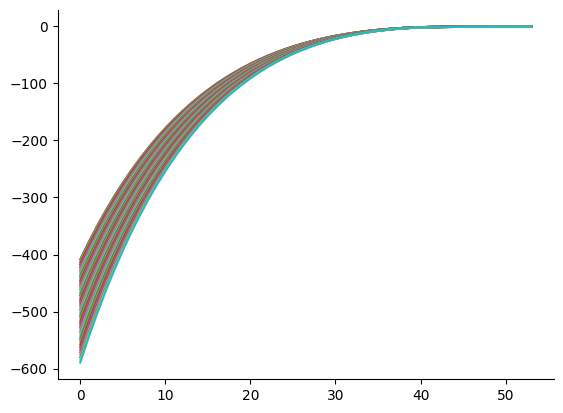

In [9]:
distort_inten =  np.sum(πd_o * g_m * (v_m - v0), axis=0)
# np.save(f"inten_multi_{λ}", distort_inten)
plt.plot(distort_inten)
plt.show()

In [10]:
np.save(f"ems_{λ}", ems)
np.save(f"v_{λ}", v0)

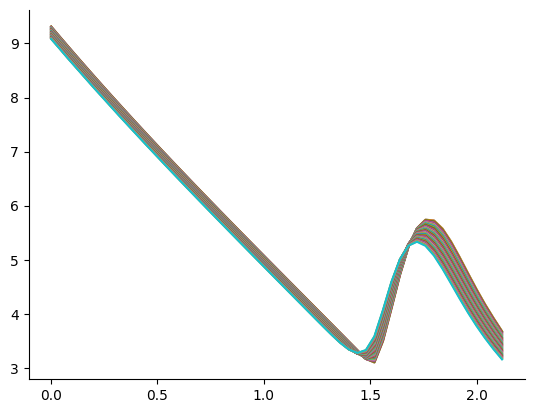

In [11]:
plt.plot(y1_grid_cap, ems)
plt.show()

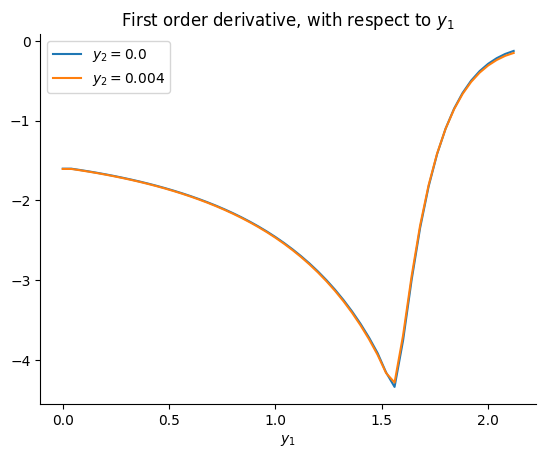

In [12]:
plt.title("First order derivative, with respect to $y_1$")
plt.plot(y1_grid_cap, v0_dy1[:,0], label=r"$y_2 = {}$".format(y2_grid[0]))
plt.plot(y1_grid_cap, v0_dy1[:,4], label=r"$y_2 = {}$".format(y2_grid[4]))
plt.xlabel(r"$y_1$")
plt.legend()
# plt.savefig("dv_dy1")
plt.show()

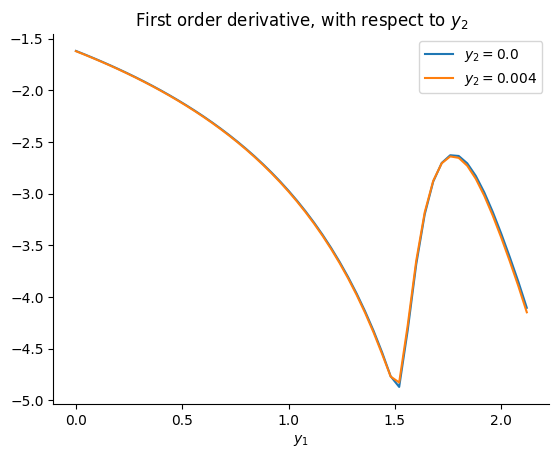

In [13]:
plt.title("First order derivative, with respect to $y_2$")
plt.plot(y1_grid_cap, v0_dy2[:,0], label=r"$y_2 = {}$".format(y2_grid[0]))
plt.plot(y1_grid_cap, v0_dy2[:,4], label=r"$y_2 = {}$".format(y2_grid[4]))
plt.xlabel(r"$y_1$")
plt.legend()
# plt.savefig("dv_dy2")
plt.show()

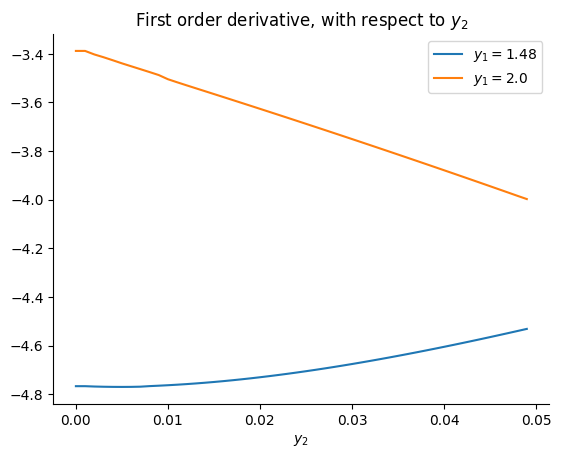

In [36]:
plt.title("First order derivative, with respect to $y_2$")
plt.plot(y2_grid, v0_dy2[37], label=r"$y_1 = {}$".format(y1_grid_cap[37]))
plt.plot(y2_grid, v0_dy2[-4], label=r"$y_1 = {}$".format(y1_grid_cap[-4]))
plt.xlabel(r"$y_2$")
plt.legend()
# plt.savefig("dv_dy2_y2")
plt.show()

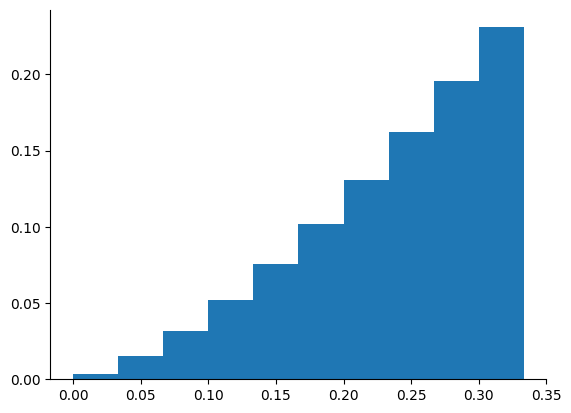

In [37]:
g_i = g_m[:, -1, 2]
plt.hist(γ3_list, weights= g_i/ np.sum(g_i, axis=0))
plt.show()

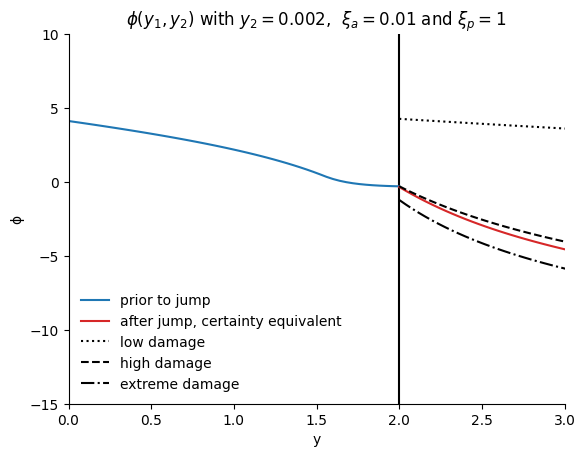

In [16]:
#
plt.plot(y1_grid[:loc_2 + 1],
         phi_mat[:loc_2 + 1, 2],
         color="tab:blue",
         label="prior to jump")
plt.plot(y1_grid[loc_2:],
         ϕ_equiv[loc_2:][:, 2],
         color="tab:red",
         label="after jump, certainty equivalent")
plt.plot(y1_grid[loc_2:],
         ϕ_list[0][loc_2:, 2],
         color="black",
         linestyle=":",
         label="low damage")
plt.plot(y1_grid[loc_2:],
         ϕ_list[10][loc_2:, 2],
         color="black",
         linestyle="--",
         label="high damage")
plt.plot(y1_grid[loc_2:],
         ϕ_list[-1][loc_2:, 2],
         color="black",
         linestyle="-.",
         label="extreme damage")

plt.legend(frameon=False)
plt.title("$ϕ(y_1, y_2)$ with $y_2 = 0.002$,  $ξ_a = 0.01$ and $ξ_p = 1$")
plt.vlines(2, ymax=10, ymin=-15, color="black")
plt.xlim(0, 3)
plt.ylim(-15, 10)
plt.xlabel("y")
plt.ylabel("ϕ")
# plt.savefig("./paper_plots/2_state_value_function.png", dpi=400, facecolor="w", edgecolor="w", bbox_inches="tight")
plt.show()

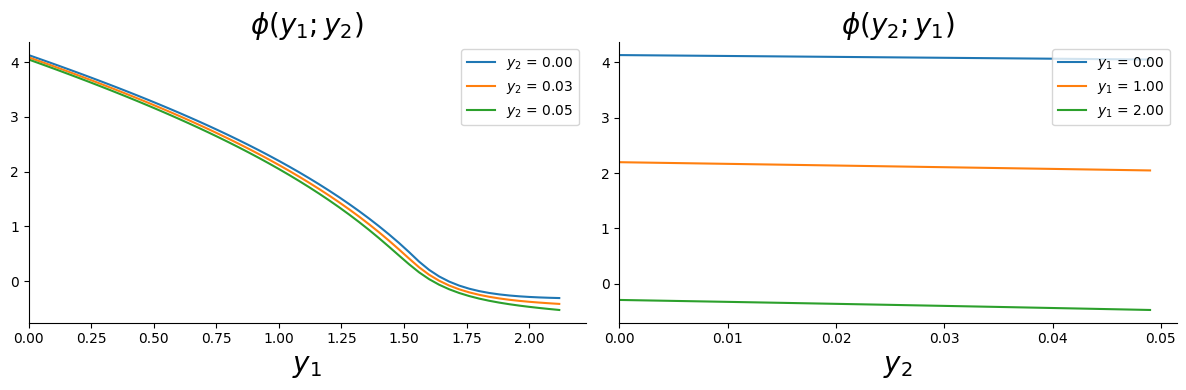

In [17]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(y1_mat_cap[:,0], v0[:,0], label="$y_2$ = {:.2f}".format(y2_mat[0,0]))
ax1.plot(y1_mat_cap[:,0], v0[:,int(n_y2/2)], label="$y_2$ = {:.2f}".format(y2_mat[0,int(n_y2/2)]))
ax1.plot(y1_mat_cap[:,0], v0[:,-1], label="$y_2$ = {:.2f}".format(y2_mat[0,-1]))
ax1.set_title('$ϕ(y_1; y_2)$', size=20)
ax1.set_xlabel("$y_1$", size=20)
ax1.legend()
# ax1.tick_params(labelsize=20)
ax1.set_xlim(0)
# ax1.set_ylim(-0.18, 0.05)
ax2.plot(y2_mat[0], v0[0], label="$y_1$ = {:.2f}".format(y1_mat[0,0]))
ax2.plot(y2_mat[int(n_y1 / 4)], v0[int(n_y1/4)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/4),0]))
ax2.plot(y2_mat[int(n_y1 / 2)], v0[int(n_y1/2)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/2),0]))
# ax2.plot(y2_mat[-1], v0[-1], label="$y_1$ = {:.2f}".format(y1_mat[-1,0]))
ax2.set_title('$ϕ(y_2; y_1)$', size=20)
ax2.set_xlabel('$y_2$', size=20)
ax2.set_xlim(0)
ax2.legend()
# ax2.set_ylim(-0.18, 0.05)
fig.tight_layout()
# plt.savefig("ϕ.png", bbox_inches="tight", facecolor="w", edgecolor="w")
plt.show()

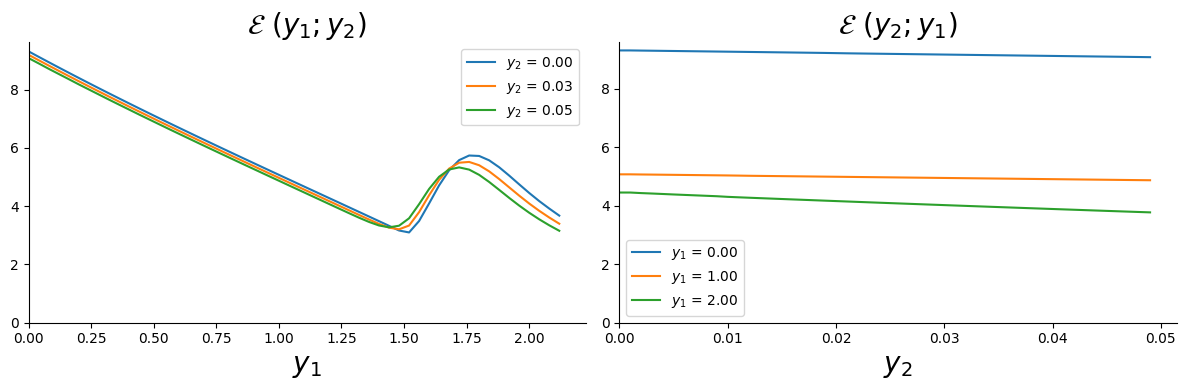

In [18]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(y1_mat_cap[:,0], ems[:,0], label="$y_2$ = {:.2f}".format(y2_mat[0,0]))
ax1.plot(y1_mat_cap[:,0], ems[:,int(n_y2/2)], label="$y_2$ = {:.2f}".format(y2_mat[0,int(n_y2/2)]))
ax1.plot(y1_mat_cap[:,0], ems[:,-1], label="$y_2$ = {:.2f}".format(y2_mat[0,-1]))
ax1.set_title('$\mathcal{E}\ (y_1; y_2)$', size=20)
ax1.set_xlabel("$y_1$", size=20)
ax1.set_xlim(0)
ax1.set_ylim(0)
ax1.legend()
# ax1.set_ylim(0, 12)
ax2.plot(y2_mat[0], ems[0], label="$y_1$ = {:.2f}".format(y1_mat[0,0]))
ax2.plot(y2_mat[int(n_y1/4)], ems[int(n_y1/4)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/4),0]))
ax2.plot(y2_mat[int(n_y1/2)], ems[int(n_y1/2)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/2),0]))
ax2.set_title('$\mathcal{E}\ ( y_2; y_1)$', size=20)
ax2.set_xlabel('$y_2$', size=20)
ax2.set_xlim(0)
ax2.set_ylim(0)
ax2.legend()
# ax2.set_ylim(0,12)
fig.tight_layout()
# plt.savefig("E.png", bbox_inches="tight", facecolor="w", edgecolor="w")
plt.show()

In [19]:
from scipy import interpolate
def simualte_ems(y1_grid, y2_grid, ems, T=100, dt=1):
    periods = int(T/dt)
    Y1t = np.zeros(periods)
    Y2t = np.zeros(periods)
    ems_t = np.zeros(periods)
    f = interpolate.interp2d(y2_grid, y1_grid, ems, )
#     f_π = interpolate.interp2d(y2_grid, y1_grid, πa, )
    y1 = θ*290
    y2 = 0.00186
    for t in range(periods):
        if y1 > np.max(y1_mat) or y2 > np.max(y2_mat):
            break
        ems_point = f(y2, y1)
#         π_list = f_π(y2, y1)
        ems_t[t] = ems_point[0]
        Y1t[t] = y1
        Y2t[t] = y2
        y1 += y2*dt
        y2 += ( - λ*y2 + λ*θ*ems_point)*dt
    return Y1t, Y2t, ems_t

In [20]:
def simulation(y1_grid, y2_grid, e_grid, λ, θ=1.86/1000., y1_0=.5394, y2_0=1.86/1000, T=100):
    e_fun = interpolate.interp2d(y1_grid, y2_grid, e_grid.T)
    Et = np.zeros(T+1)
    y1t = np.zeros(T+1)
    y2t = np.zeros(T+1)
    for i in range(T+1):
#         y2_0 = max(y2_0, 0)
#         y2_0 = min(y2_0, 0.05)
        Et[i] = e_fun(y1_0, y2_0)
        y1t[i] = y1_0
        y2t[i] = y2_0
        y2_0 = np.exp(-λ)*y2_0 + (1 - np.exp(-λ))*θ*Et[i] 
#         y2_0 = max(y2_0, 0)
        y1_0 = y1_0 + y2_0
    return Et, y1t, y2t

In [21]:
def simulation_1d(y_grid, e_grid, θ=1.86/1000., y_0=1.1, T=100):
    e_fun = interpolate.interp1d(y_grid, e_grid)
    Et = np.zeros(T+1)
    yt = np.zeros(T+1)
    for i in range(T+1):
        Et[i] = e_fun(y_0)
        yt[i] = y_0
        y_0 = y_0 + θ*Et[i] 
    return Et, yt

In [22]:
ems_1state = np.load("ems_1state.npy")
# ems_2state = np.load("ems_2state.npy")

In [23]:
i = 0
et1, yt1 = simulation_1d(np.arange(0, 5 + 0.01,  0.01), ems_1state[0], θ=np.mean(θ_list), y_0=2)
et2, y1t2, y2t2 = simulation(y1_grid, y2_grid, ems_list[0], λ, θ=np.mean(θ), y1_0=2)

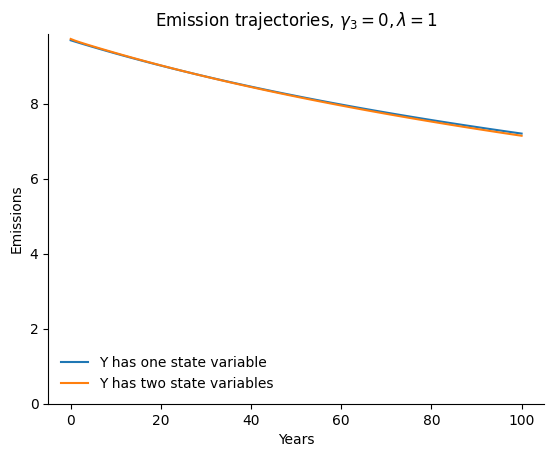

In [24]:
plt.title(f"Emission trajectories, $γ_3 = 0, λ = {λ}$")
plt.plot(et1, label="Y has one state variable")
plt.plot(et2, label="Y has two state variables")
plt.legend(frameon=False, loc=3)
plt.ylim(0)
plt.ylabel("Emissions")
plt.xlabel("Years")
# plt.savefig("ems_1_2_5")
plt.show()

In [25]:
et_prejump, y1t_prejump, y2t_prejump = simulation(y1_grid_cap,
                                                  y2_grid,
                                                  ems,
                                                  λ,
                                                  θ=np.mean(θ_list),
                                                  y1_0 = 1.1,
                                                  y2_0=np.mean(θ_list),
                                                  T=110
                                                 )

In [38]:
simul = {
    "et": et_prejump,
    "y1t": y1t_prejump,
    "y2t": y2t_prejump,
}

pickle.dump(simul, open(f"simul_{λ}", "wb"))

In [39]:
y1t_prejump

array([1.1       , 1.10618573, 1.11391215, 1.1221616 , 1.13056221,
       1.13897839, 1.14736087, 1.15569195, 1.16396544, 1.17217941,
       1.18033343, 1.18842765, 1.19646239, 1.20443803, 1.21235491,
       1.22021339, 1.22801386, 1.23575675, 1.24344248, 1.25107152,
       1.25864432, 1.26616131, 1.27362292, 1.28102955, 1.28838162,
       1.29567955, 1.30292375, 1.31011461, 1.31725252, 1.32433785,
       1.33137091, 1.33835199, 1.34528145, 1.35215968, 1.35898704,
       1.36576391, 1.37249076, 1.37916798, 1.38579597, 1.39237508,
       1.39890568, 1.40538813, 1.41182311, 1.41821115, 1.42455265,
       1.43084794, 1.43709735, 1.44330118, 1.44946115, 1.45557922,
       1.46165625, 1.46769264, 1.47368868, 1.47964457, 1.48556052,
       1.49145711, 1.49734314, 1.50322186, 1.50909444, 1.51496131,
       1.52082261, 1.52668877, 1.53262748, 1.53866536, 1.54481384,
       1.55107879, 1.55746394, 1.56397228, 1.57062871, 1.5774595 ,
       1.58447774, 1.59169169, 1.59910798, 1.60673242, 1.61457

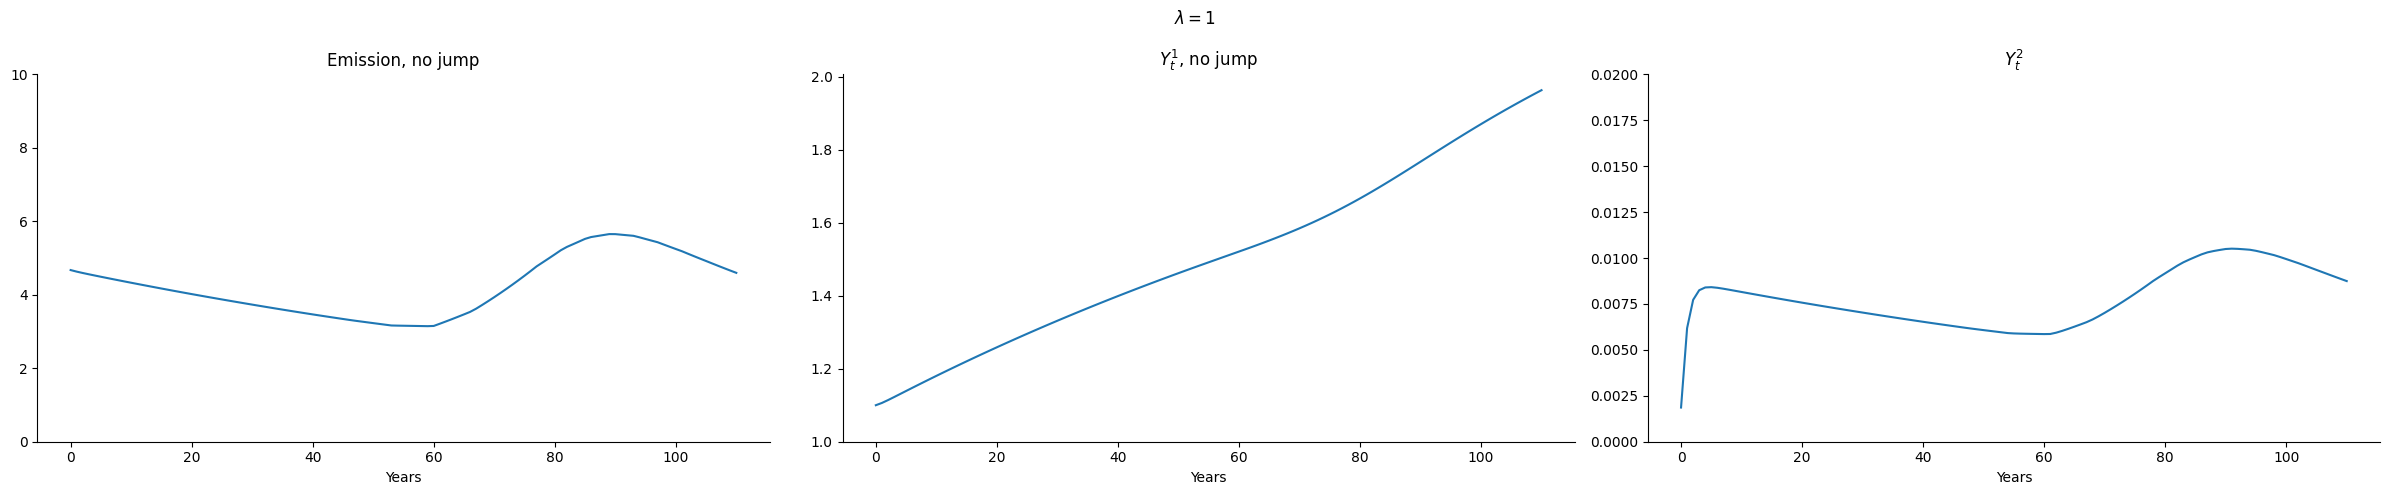

In [40]:
fig = plt.figure(figsize=(24, 5))
fig.suptitle(f"$\lambda = {λ}$")
plt.subplot(131)
plt.title("Emission, no jump")
plt.plot(et_prejump)
plt.ylim(0,10)
plt.xlabel("Years")
plt.subplot(132)
plt.xlabel("Years")
plt.title(r"$Y_t^1$, no jump")
plt.plot(y1t_prejump)
plt.ylim(1)
plt.subplot(133)
plt.title(r"$Y_t^2$")
plt.plot(y2t_prejump)
plt.ylim(0, 0.02)
plt.xlabel("Years")
plt.tight_layout()
# plt.savefig(f"e_y1_y2_{λ}")
plt.show()

In [29]:
y2_grid

array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
       0.009, 0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017,
       0.018, 0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026,
       0.027, 0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035,
       0.036, 0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044,
       0.045, 0.046, 0.047, 0.048, 0.049])

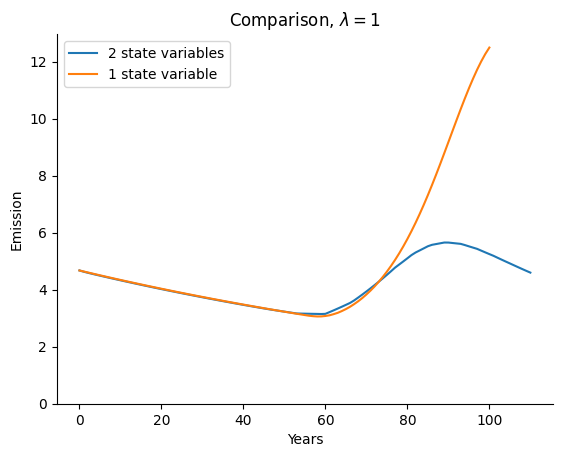

In [31]:
et_1state = np.load("et_1state_cal.npy")
plt.plot(et_prejump, label="2 state variables")
plt.plot(et_1state, label="1 state variable")
plt.ylim(0)
plt.legend()
plt.xlabel("Years")
plt.ylabel("Emission")
plt.title(f'Comparison, $\lambda = {λ}$')
# plt.savefig(f"emissions_2_{λ}")
plt.show()

In [50]:
# simulate
def simulate_logkapital(invkap, αₖ,  σₖ, κ, k0, T=100, dt=1):
    periods = int(T/dt)
    Kt = np.zeros(periods)
    i = invkap
     # log capital
    Kt[0] = np.log(k0)
    k = np.log(k0)
    for t in range(periods-1):
        k +=   (αₖ + i - κ/2*i**2 - .5*σₖ**2)*dt
        Kt[t+1] = k
    return Kt

In [51]:
invkap = 0.09
α = 0.115
αₖ = - 0.043
σₖ = 0.0095
κ = 6.667
k0 = 85/α

In [54]:
Kt = simulate_logkapital(invkap, αₖ, σₖ, κ,  k0, T=111)
MC = δ*(1-η)/((α - invkap)*np.exp(Kt))
scc = η*(α - invkap)*np.exp(Kt)/(1-η)/et_prejump*1000

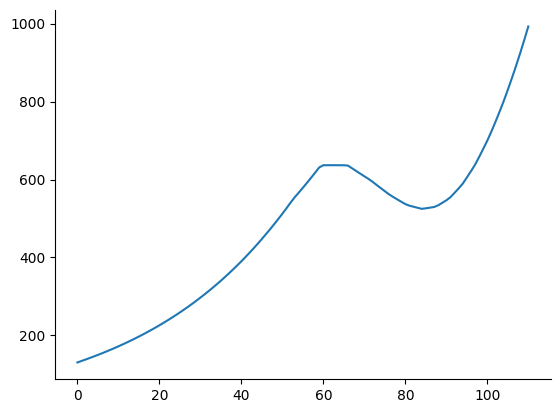

In [55]:
plt.plot(scc)
plt.show()

In [33]:
np.save(f"scct_{λ}", scc)